<h1><center>Sentiment Analysis</center></h1>
<h3><center>Sentiment analysis of IMDB movie reviews</center></h3>

The aim of the project is perform Sentiment analysis of the reviews submitted on IMDB. IMDB is an online database of information related to visual entertainments like movies, TV series etc. It is a popular medium for people to review and rate movies. IMDB ratings are considered as benchmark for success of multiple movies.<br>

The dataset contains 50000 reviews, 25000 of each sentiment - positive (1) and negative (0).

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pickle
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv('/home/raj/Downloads/movie_data.csv')
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


For the sentiment analysis, it is important to clean the text of the reviews. The following steps are performed in order to clean them, 

   * Lower case
   * Remove punctuations
   * Remove paranthesis
   * Remove stop words
   
After cleaning, only the important words of the reviews that give insights to its sentiments remain.

In [3]:
def preprocessing(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = re.sub('[\W]+',' ',text.lower()) + ' '.join(emoticons).replace('-','')
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in ENGLISH_STOP_WORDS])
    return text

df.review = df.review.apply(preprocessing)
df.head(5)

,review,sentiment
0,1974 teenager martha moxley maggie grace moves...,1
1,ok really like kris kristofferson usual easy g...,0
2,spoiler read think watching movie waste time w...,0
3,hi people seen wonderful movie im sure thet li...,1
4,recently bought dvd forgetting just hated movi...,0


To gain insight into the kind of words used for both the sentiments, wordclouds are created for each class of sentiment. The word cloud highlights the most common words, showing what words usually appear in a review of that kind of sentiment.<br>

The first one is a word cloud for all the positive sentiment reviews.

(-0.5, 1199.5, 799.5, -0.5)

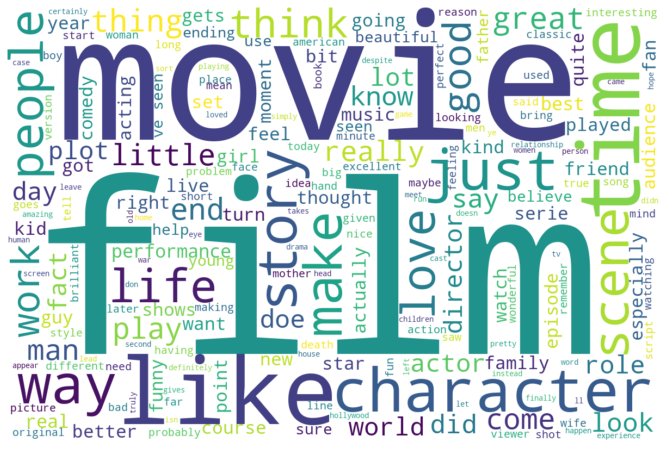

In [4]:
text= ""

def get_all_text(t):
    global text
    text = text+t+" "
    
df.review[df.sentiment == 1].apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= ENGLISH_STOP_WORDS,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')

The next plot is a wordcloud for all negative sentiment reviews.

(-0.5, 1199.5, 799.5, -0.5)

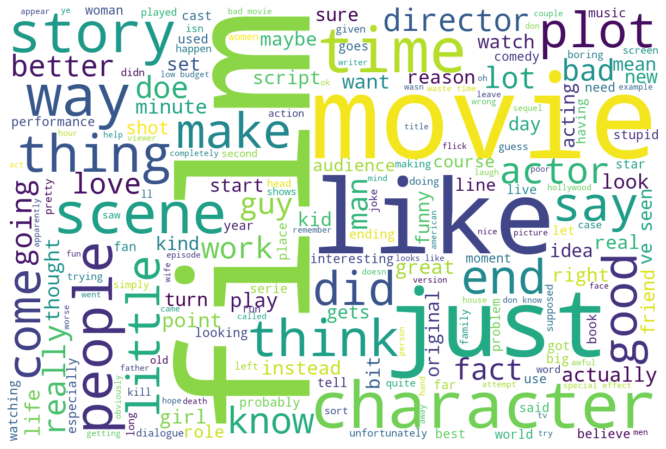

In [5]:
text= ""

def get_all_text(t):
    global text
    text = text+t+" "
    
df.review[df.sentiment == 0].apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= ENGLISH_STOP_WORDS,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')

The two plots show interesting results. Wordclouds show the most frequent words with the largest font and the font size decreases with frequency. Both the plots show similar words - film, movie, like, time, character etc. This goes to show that a word that appears so frequently in the reviews does not help in the classification of the review. This will be dealt with later on.

There can be multiple words in the reviews that are common to a stem, for example the words do, doing, done mean the same thing and are inflections of a common root form or stem - do. Treating such words as individuals can increase the dimensionality of the data. Thus a stemmer is used to reduce all words to its root. These stems are not dictionary format (as lemmas) and individually may not mean anything.

In [6]:
def stem_text(text):
    porter = PorterStemmer()
    words = word_tokenize(text)
    return " ".join([porter.stem(word) for word in words])

df.review = df.review.apply(stem_text)
df.head(5)

,review,sentiment
0,1974 teenag martha moxley maggi grace move hig...,1
1,ok realli like kri kristofferson usual easi go...,0
2,spoiler read think watch movi wast time way pl...,0
3,hi peopl seen wonder movi im sure thet like lo...,1
4,recent bought dvd forget just hate movi versio...,0


As discussed earlier, most frequent words in the reviews do not actually help in classifying the review's sentiment. Firstly, each review is converted into a tokenized vector. For each word in the review a tfidf weight is calculated. The tfidf weight is large for rare words and small for common words, this way frequent words are given less importance in a review and rare words are given more.

In [7]:
tfidf= TfidfVectorizer(use_idf= True, norm= 'l2', smooth_idf= True)

y= df.sentiment.values
X= tfidf.fit_transform(df.review)

The vectorized list of reviews become the input features and the sentiment column is the target. This is now split into train and test sets. The split is of 65:35.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.35,
    random_state= 1, 
    shuffle= False
)

A logistic regression model is trained for this classification. For the c parameter tuning, LogisticRegressionCV is used, which will perform k-fold cross validation and grid search to find the optimal parameter based on accuracy. 

In [9]:
model = LogisticRegressionCV(
    cv= 5,
    scoring= 'accuracy',
    max_iter= 300,
    n_jobs= -1,
    verbose= 3,
    random_state= 0
)
model.fit(X_train,y_train)

pred = model.predict(X_test)
print(classification_report(pred,y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


              precision    recall  f1-score   support

           0       0.89      0.90      0.89      8640
           1       0.90      0.89      0.89      8860

    accuracy                           0.89     17500
   macro avg       0.89      0.89      0.89     17500
weighted avg       0.89      0.89      0.89     17500



The classification report shows good percentages, 89% for precision and recall and f1-score. The equal values for both mean that the classifier is good at predicting and understanding the classes.<br>

The next model to be tried is the Support Vector Machine.

In [15]:
sv_model = SVC(verbose=2, probability= True, random_state= 1)
sv_model.fit(X_train,y_train)

pred = sv_model.predict(X_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      8576
           1       0.90      0.89      0.90      8924

    accuracy                           0.89     17500
   macro avg       0.89      0.89      0.89     17500
weighted avg       0.89      0.89      0.89     17500



The classification report of the SupporVector machine shows about the same results as the LogisticRegression model. The two models SupportVector and LogisticRegression are two good candidates.<br>

The next model tried is the RandomForest model.

In [11]:
rf_model = RandomForestClassifier(n_estimators= 200, n_jobs= -1, verbose= 1)
rf_model.fit(X_train, y_train)

pred = rf_model.predict(X_test)
print(classification_report(pred, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      8771
           1       0.85      0.86      0.86      8729

    accuracy                           0.86     17500
   macro avg       0.86      0.86      0.86     17500
weighted avg       0.86      0.86      0.86     17500



[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


The RandomForest model achieves an 86% accuracy, precision, recall and f1-score. All the percentages are same and hence indicates that the model predicts and understands the classes well. The lesser accuracy as compared to the two models previously shows that RandomForest doesnot truly understand some cases as well as Logistic or SupportVector.<br>

The classification report shows all the models perform quite well and close to eachother. The ROC curve for each model is plotted below. It shows the AUC and TPR vs FPR of the model. The more the AUC the better the model performs.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


Area under the curve - Logistic:  0.9572116101664508
Area under the curve - RandomForest:  0.9296498684453036
Area under the curve - Support Vector:  0.9592376816672183


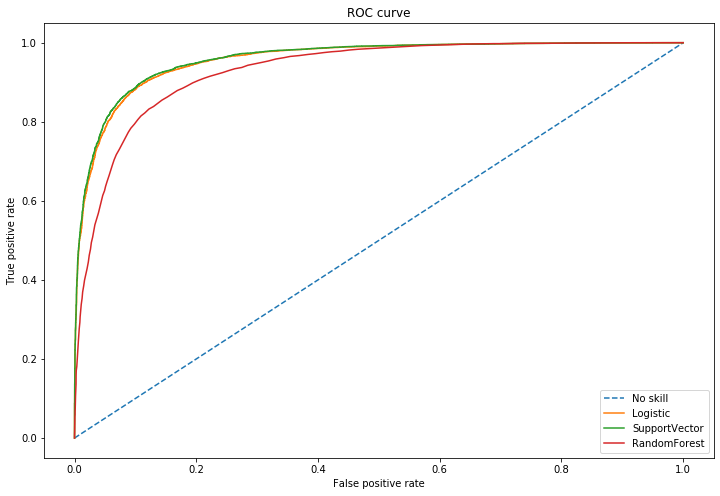

In [16]:
no_skill_probs = [0 for _ in range(len(y_test))]
lrmod_probs = model.predict_proba(X_test)[:,1]
rfmod_probs = rf_model.predict_proba(X_test)[:,1]
svmod_probs = sv_model.predict_proba(X_test)[:,1]

roc_score_lr = roc_auc_score(y_test, lrmod_probs)
roc_score_rf = roc_auc_score(y_test, rfmod_probs)
roc_score_sv = roc_auc_score(y_test, svmod_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill_probs)
lrmod_fpr, lrmod_tpr, _ = roc_curve(y_test, lrmod_probs)
rfmod_fpr, rfmod_tpr, _ = roc_curve(y_test, rfmod_probs)
svmod_fpr, svmod_tpr, _ = roc_curve(y_test, svmod_probs)

print("Area under the curve - Logistic: ",roc_score_lr)
print("Area under the curve - RandomForest: ",roc_score_rf)
print("Area under the curve - Support Vector: ",roc_score_sv)

plt.figure(figsize= (12,8))
plt.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'No skill')
plt.plot(lrmod_fpr, lrmod_tpr, label= 'Logistic')
plt.plot(svmod_fpr, svmod_tpr, label= 'SupportVector')
plt.plot(rfmod_fpr, rfmod_tpr, label= 'RandomForest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc= 'lower right')

The models - LogisticRegression and SupportVector have very close Area under the curves. RandomForest comparatively underperforms. The final model chosen is the SupportVector machine as it slightly out-performs the LogisticRegression model.

In [17]:
saved_model = open('saved_model.sav','wb')
pickle.dump(sv_model, saved_model)
saved_model.close()

In conclusion, the SupportVector model offers a good accuracy - 89% in predicting the sentiments of movie reviews from IMDB.